In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import seaborn as sns
import ast
import warnings
from transformers import pipeline
import torch
warnings.filterwarnings("ignore")


# Topics des articles ECB

On s'intéresse a la répartition des sujets par articles

In [2]:
df_topic = pd.read_csv("./data/df_topics_large.csv")

In [3]:
df_texte = pd.read_parquet("./data/ecb_press.parquet")

In [4]:
df_texte.shape

(2168, 5)

In [5]:
df_3 = df_texte.merge(df_topic[["url", "title", "topic"]], on="url", how="left").drop_duplicates(subset="url")


In [6]:
df_3[df_3["topic"].isna()==0]

,language,url,date,content,title_2,title,topic
0,en,https://www.ecb.europa.eu/euro/digital_euro/ti...,2024-12-12,Feedback on Fit in the\nEcosystem consultation...,PDF Title,Summary of feedback on Fit in the ecosystem – ...,['Digital euro']
1,en,https://www.ecb.europa.eu/euro/digital_euro/ti...,2024-12-12,ECB-PUBLIC\nPreliminary\nmethodology for\ncali...,PDF Title,Update on work on methodology for holding limi...,['Digital euro']
2,en,https://www.ecb.europa.eu/euro/digital_euro/ti...,2024-12-12,WORKING DOCUMENT - PRELIMINARY– FOR FEEDBACK O...,PDF Title,Annex to preliminary methodology for holding l...,['Digital euro']
3,en,https://www.ecb.europa.eu/euro/digital_euro/ti...,2024-12-12,Innovation partnerships\nNico Schmidt\n10/12/2...,PDF Title,Update on Experimentation – agenda item 4,['Digital euro']
4,en,https://www.ecb.europa.eu/euro/digital_euro/ti...,2024-12-12,ERPB Technical\nSessions in 2025\n10 December ...,PDF Title,Timeline of 2025 ERPB sessions – agenda item AOB,['Digital euro']
...,...,...,...,...,...,...,...
1801,en,https://www.ecb.europa.eu/pub/pdf/annex/ecb.sp...,2018-04-09,Economic developments\nPeter Praet\nin the eur...,Commentary,Slides from the presentation,"['Euro area', 'Economic development']"
1809,en,https://www.ecb.europa.eu/pub/pdf/annex/ecb.sp...,2018-02-26,26-02-2018 1\n1-001-0000\nCOMMITTEE ON ECONOMI...,Commentary,Transcript of the hearing,"['Policies', 'Economic development', 'Monetary..."
1810,en,https://www.ecb.europa.eu/pub/pdf/annex/ecb.sp...,2018-02-23,Benoît Cœuré The persistence and\nMember of th...,Commentary,Presentation slides,"['Monetary policy', 'Policies', 'Asset purchas..."
1812,en,https://www.ecb.europa.eu/pub/pdf/annex/ecb.sp...,2018-02-16,Benoît Cœuré\nTrade as an engine of\nMember of...,Commentary,Slides from the presentation,"['Euro area', 'Economic development']"


In [46]:
df = pd.read_csv("df_topic_title.csv", index_col="date", parse_dates=True)
df["topic"] = df["topic"].apply(ast.literal_eval)

In [69]:
df["topic"].iloc[0]

['Digital euro']

In [72]:
df_topic["topic"] = df_topic["topic"].apply(ast.literal_eval)

In [73]:
df_temp = pd.concat([df, df_topic.set_index("date")], axis=0)

In [84]:
def custom_aggregate(series):
    if series.dtype == "object" and any(isinstance(v, list) for v in series.dropna()):

        merged = set()
        for lst in series.dropna():
            merged.update(lst)
        return list(merged)
    else:

        return series.dropna().iloc[0] if len(series.dropna()) > 0 else np.nan

df = (
    df_temp.reset_index().groupby("url", as_index=False)
    .agg(custom_aggregate)
)
df.set_index("date", inplace=True)

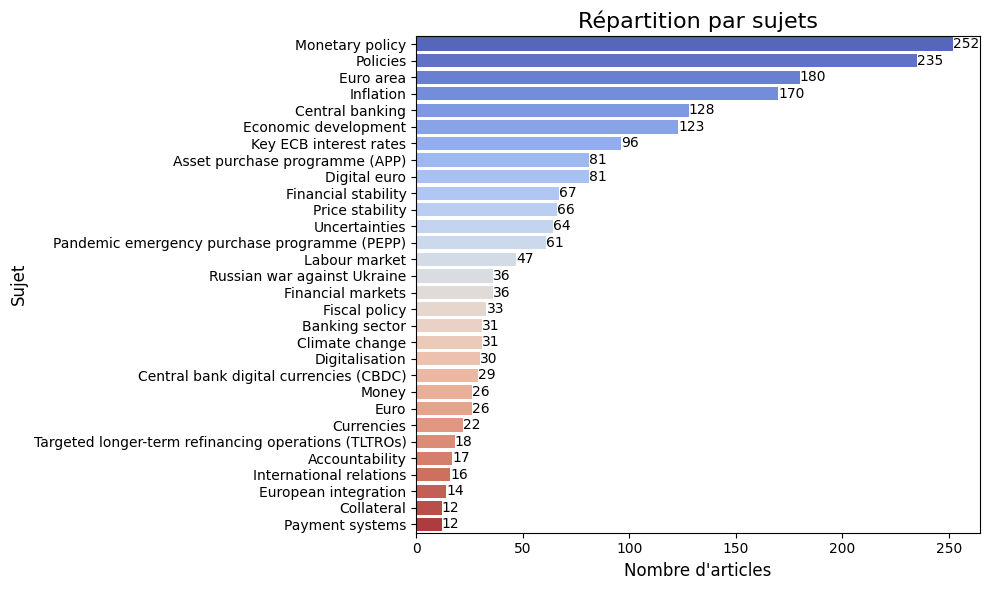

In [87]:
df_exploded = df.explode("topic")

topic_counts = df_exploded["topic"].value_counts().reset_index()
topic_counts.columns = ["topic", "count"]

top_topics = topic_counts.head(30)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_topics,
    x="count",
    y="topic",
    palette="coolwarm",
    legend=False,
)
plt.title("Répartition par sujets", fontsize=16)
plt.xlabel("Nombre d'articles", fontsize=12)
plt.ylabel("Sujet", fontsize=12)

for index, value in enumerate(top_topics["count"]):
    plt.text(value, index, str(value), va="center", ha="left", fontsize=10)

plt.tight_layout()
plt.show()

In [89]:
df.index = pd.to_datetime(df.index, errors='coerce')

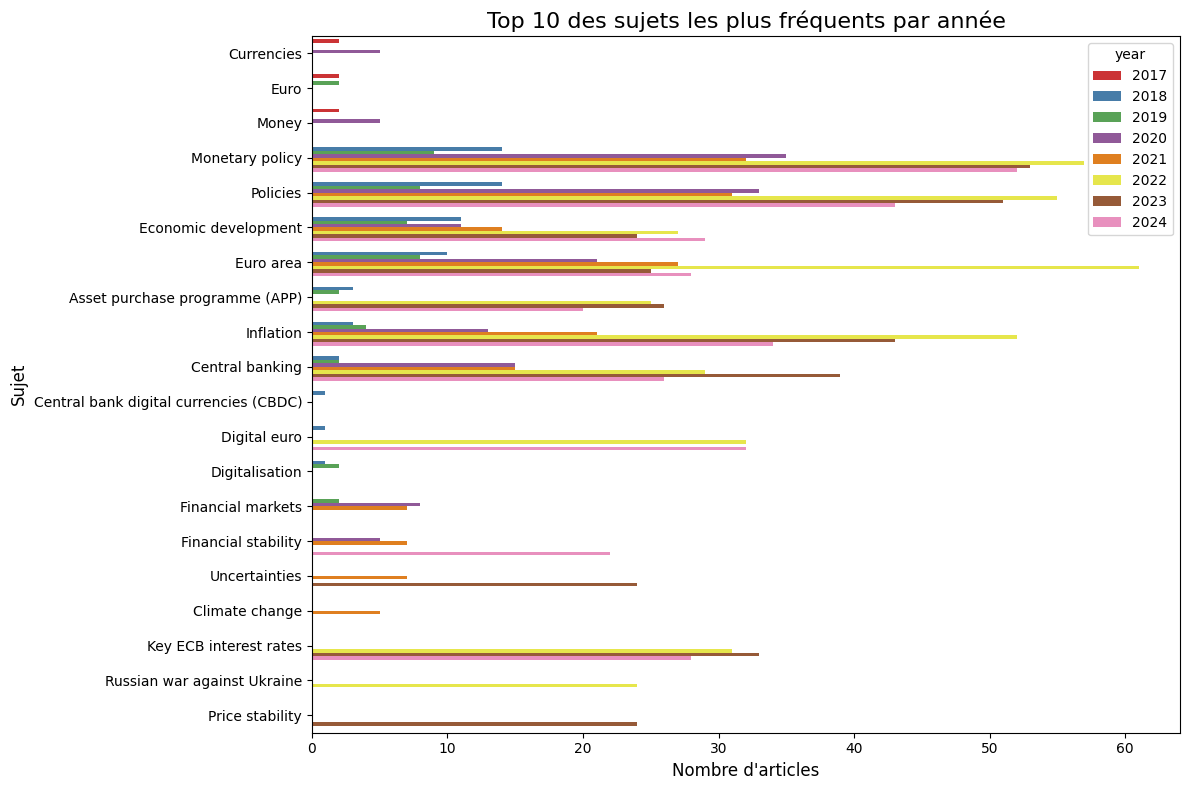

In [90]:
df['year'] = df.index.year

df_exploded = df.explode('topic')

yearly_counts = df_exploded.groupby(['year', 'topic']).size().reset_index(name="count")
top_yearly_counts = yearly_counts.groupby('year').apply(lambda x: x.nlargest(10, 'count')).reset_index(drop=True)

plt.figure(figsize=(12, 8))
sns.barplot(data=top_yearly_counts, x="count", y="topic", hue="year", palette="Set1")
plt.title("Top 10 des sujets les plus fréquents par année", fontsize=16)
plt.xlabel("Nombre d'articles", fontsize=12)
plt.ylabel("Sujet", fontsize=12)
plt.tight_layout()
plt.show()

On a beaucoup de sujets et d'articles, mais un article peut avoir plusieurs sujets. Afin de grouper les sujets entre eux, on peut appliquer un algorithme de clustering (Kmeans) pour grouper les sujets "proches" entre eux en considérant la matrice de confusion (pour chaque pair de sujets, combien d'articles traite les 2 sujets simultanément)

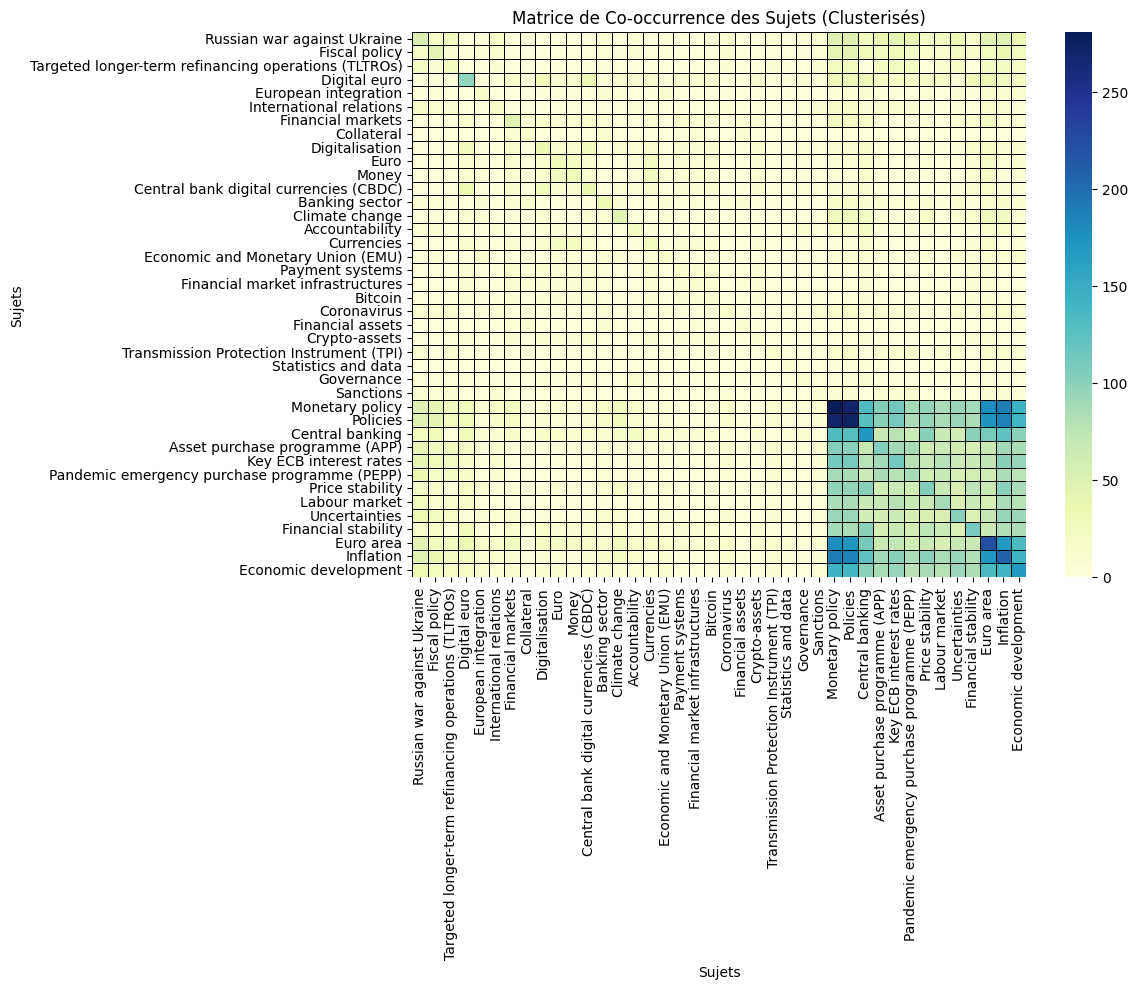

In [91]:
all_topics = df['topic'].explode()

topic_counts = all_topics.value_counts()

top_topics = topic_counts.head(40).index.tolist()

binary_matrix = pd.DataFrame(0, index=df.index, columns=top_topics)

for idx, row in df.iterrows():
    for topic in row['topic']:
        if topic in top_topics:
            binary_matrix.at[idx, topic] = 1

co_occurrence_matrix = binary_matrix.T.dot(binary_matrix)

kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(co_occurrence_matrix)

clusters = pd.DataFrame({
    'topic': co_occurrence_matrix.columns,
    'cluster': kmeans.labels_
})

sorted_topics = clusters.sort_values('cluster')['topic'].tolist()

co_occurrence_matrix_sorted = co_occurrence_matrix.loc[sorted_topics, sorted_topics]

plt.figure(figsize=(12, 10))
sns.heatmap(co_occurrence_matrix_sorted, cmap='YlGnBu', annot=False, fmt='d', linewidths=0.5, linecolor='black')

plt.title("Matrice de Co-occurrence des Sujets (Clusterisés)")
plt.xlabel("Sujets")
plt.ylabel("Sujets")
plt.tight_layout()
plt.show()


In [92]:
for cluster in clusters["cluster"].unique():
    print("*"*20, f"\nCluster {cluster}:")
    print(clusters[clusters["cluster"]==cluster]["topic"].to_list())

******************** 
Cluster 2:
['Monetary policy', 'Policies']
******************** 
Cluster 4:
['Euro area', 'Inflation', 'Economic development']
******************** 
Cluster 3:
['Central banking', 'Key ECB interest rates', 'Asset purchase programme (APP)', 'Financial stability', 'Price stability', 'Uncertainties', 'Pandemic emergency purchase programme (PEPP)', 'Labour market']
******************** 
Cluster 1:
['Digital euro', 'Financial markets', 'Banking sector', 'Climate change', 'Digitalisation', 'Central bank digital currencies (CBDC)', 'Money', 'Euro', 'Currencies', 'Accountability', 'International relations', 'European integration', 'Collateral', 'Payment systems', 'Economic and Monetary Union (EMU)', 'Financial market infrastructures', 'Transmission Protection Instrument (TPI)', 'Crypto-assets', 'Financial assets', 'Coronavirus', 'Bitcoin', 'Sanctions', 'Governance', 'Statistics and data']
******************** 
Cluster 0:
['Russian war against Ukraine', 'Fiscal policy', 'T

## Analyse des titres

Les textes des articles récupérées peuvent être très long, avant de chercher a faire de l'analyse de sentiment, on regarde si à l'aide d'un modèle pré-entrainé, faire l'analyse des sentiments sur les titres des articles peut être intéressant

In [93]:
nlp = pipeline("sentiment-analysis", model="ahmedrachid/FinancialBERT-Sentiment-Analysis")


Device set to use cuda:0


In [94]:
df_title = df[df["title"].isna()==0].copy()

In [95]:
list_titles = df_title["title"].to_list()
sentiments = nlp(list_titles)

df_title["sentiment_title"] = [x["label"] for x in sentiments]

In [97]:
df_title[df_title["sentiment_title"]!="neutral"].shape

(7, 7)

seulement 7 articles sur les 500 ont un label différent de "neutre".

In [99]:
df_title[df_title["sentiment_title"]=="positive"][["title"]]

,title
date,
2022-11-30,Digital central bank money for Europeans – get...
2022-10-13,Can the ECB gain credibility by explaining its...
2022-10-27,ECB recalibrates targeted lending operations t...
2023-04-24,ECB and EIOPA call for increased uptake of cli...
2024-11-07,Survey on the Access to Finance of Enterprises...
2022-09-29,"Letter from Fabio Panetta to Irene Tinagli, EC..."


In [103]:
df_title[df_title["sentiment_title"]=="negative"]["title"].iloc[0]

'The ECB’s balance sheet reduction: an interim assessment'

En regardant de plus près certains résultats, on peut voir que le modèle fait en plus des erreurs:

In [111]:
df_title[df_title["sentiment_title"]=="positive"].iloc[2]["title"]

'ECB recalibrates targeted lending operations to help restore price stability over the medium term'

L'exemple ci dessus est neutre, mais le prédicteur bert a du se concentrer sur la négation pour en déduire un label négatif.

In [113]:
nlp(["The economy is currently in a critical condition.",
     "Experts assert that we will not experience a recession for the remainder of our lives.",
     "The financial markets are performing well.",
     "covid 19 is going to come back !"])

[{'label': 'neutral', 'score': 0.9983395338058472},
 {'label': 'negative', 'score': 0.9986432194709778},
 {'label': 'positive', 'score': 0.9998288154602051},
 {'label': 'neutral', 'score': 0.9994383454322815}]

Les modèles BERT ici peuvent dépendre grandement des données avec lesquels ils ont été entraînés, particulièrement il faut idéalement qu'elles soient semblables à nos données.